In [495]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt, image as mpimg
from matplotlib.lines import Line2D
import seaborn as sns
import os
import scikit_posthocs as sp
import pandas as pd
import openpyxl

1. EUCLIDEAN DISTANCE RESULTS

In [460]:
#initialise values and import data
joints = ["hip", "knee", "ankle"]  # List of joints in the specified order
ds = "test"  # Dataset type

landmarks  = ["FHC", "FIP", "FMDU", "FKC" , "FME", "FLE", "FTP", "TKC", "FMCP", "FLCP", "TMCP",
               "TLCP", "FMDL", "TMDU", "TAC", "TMDL"]

hipnum = 3
kneenum = 11
anklenum = 2

#load euclidean distance data - all into one np array

#initialize empty list to store data from all joints
eu_dist_data = []

for joint in joints:
    #load  dataset for current joint
    data = np.load(f"eu_dist/eu_dist_{ds}_{joint}.npy").T
    #append to list
    eu_dist_data.append(data)


#vertical concatenation
eu_dist_data = np.concatenate(eu_dist_data, axis=0)

data_len = (eu_dist_data.shape[0])

In [461]:
# Function to identify and remove outliers based on MAD, and print outlier details
def remove_mad_outliers(x, threshold=3):

    k = 1.4826  # Constant to make the MAD a consistent estimator for the standard deviation for large samples under normal distribution
    cleaned_data = [] #array to store data without outliers
        
    for i, group in enumerate(x): #np array in

        med_group = np.median(group)
        mad_group = k * np.median(np.abs(x - med_group))
        m = (group - med_group) / mad_group
        not_outliers = (m >= -threshold) & (m <= threshold)
        outliers = np.where((m < -threshold) | (m > threshold))[0]
        
        # print details about outliers
        if len(outliers) > 0:
            print(f"Outliers found at indices: {outliers}, with values: {group[outliers]}")
        else:
            print("No outliers found.")
        
        cleaned_group = group[not_outliers]
        cleaned_data.append(cleaned_group)
        print(f"Removed {len(group) - len(cleaned_group)} outliers\n")
        
    # Convert each group back to a NumPy array without padding
    cleaned_data= np.array([np.array(group) for group in cleaned_data], dtype=object)
    return cleaned_data

In [ ]:
clean_eu_dist = remove_mad_outliers(eu_dist_data)

In [ ]:
#stats tables
data = clean_eu_dist #eu_dist_data or clean_eu_dist

#calculate stats measures
stats_lmk = np.zeros((data_len, 3))
stats_total = np.zeros((4,3))

#iterate through landmarks
for i, lmk in enumerate(data):
    mean = np.mean(lmk)
    median = np.median(lmk)
    stdev = np.std(lmk)

    stats_lmk[i] = [mean, median, stdev]

print(stats_lmk)

hip_data = np.concatenate(data[0:hipnum+1]) 
knee_data = np.concatenate(data[hipnum+1:hipnum+kneenum+1]) 
ankle_data = np.concatenate(data[hipnum+kneenum+1:data_len]) 
all_data = np.concatenate(data[0:data_len]) 


stats_total =[[np.mean(hip_data), np.median(hip_data), np.std(hip_data)],
        [np.mean(knee_data), np.median(knee_data), np.std(knee_data)],
        [np.mean(ankle_data), np.median(ankle_data), np.std(ankle_data)],
        [np.mean(all_data), np.median(all_data), np.std(all_data)]]

print (stats_total)

In [ ]:
means = stats_lmk[:,0]
print(means)

Boxplot

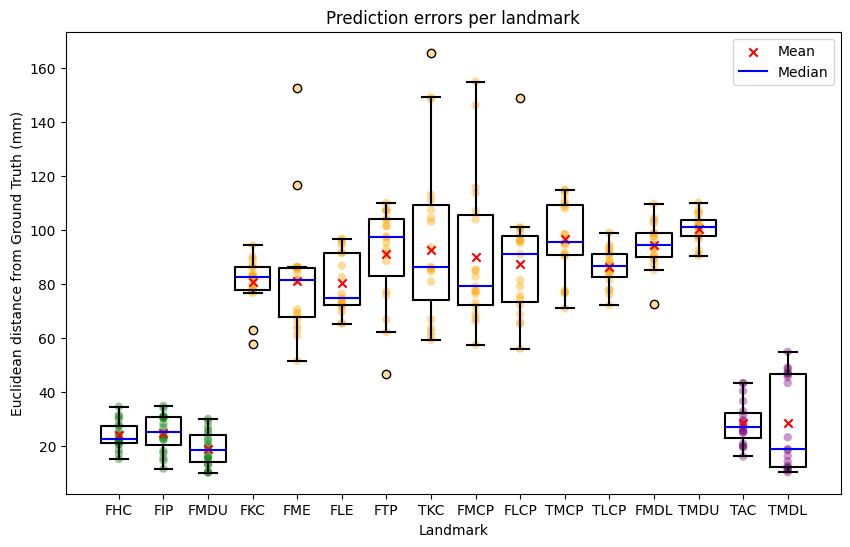

In [464]:
data = eu_dist_data #eu_dist_data or cleaned_data

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data.T,fill=False,color='0', medianprops={'color': 'blue'}) #data array must be transpose

#95 percentile whiskers
#sns.boxplot(data=data.T,fill=False,color='0', medianprops={'color': 'blue'}, whis=(5,95))

plt.xticks(ticks=np.arange(0, 16), labels=landmarks)

# colours for each joint
colours = ['green'] * hipnum + ['orange'] * kneenum + ['purple'] * anklenum  # Blue for hip, Green for knee, Red for ankle

# plot all data points
for i, (row, colour) in enumerate(zip(data, colours)):
    # Generate x positions for each group's data points
    x_positions = np.full(shape=row.shape, fill_value=i)
    plt.scatter(x_positions, row, color=colour, alpha=0.4, edgecolor='none')


# get mean of each dataset and plot 
means = stats_lmk[:,0]
mean_plot = plt.scatter(range(len(means)), means, color='red', marker='x', label='Mean')

#add median line to legend
median_line = Line2D([0], [0], color="blue", label='Median')


# Labels
plt.xlabel('Landmark')
plt.ylabel('Euclidean distance from Ground Truth (mm)')
plt.title('Prediction errors per landmark')
plt.legend(handles=[mean_plot, median_line], loc='upper right')

# Save plot as image
plt.savefig(f"images/boxplot_{ds}.png")

# Display plot
plt.show()

plt.close()

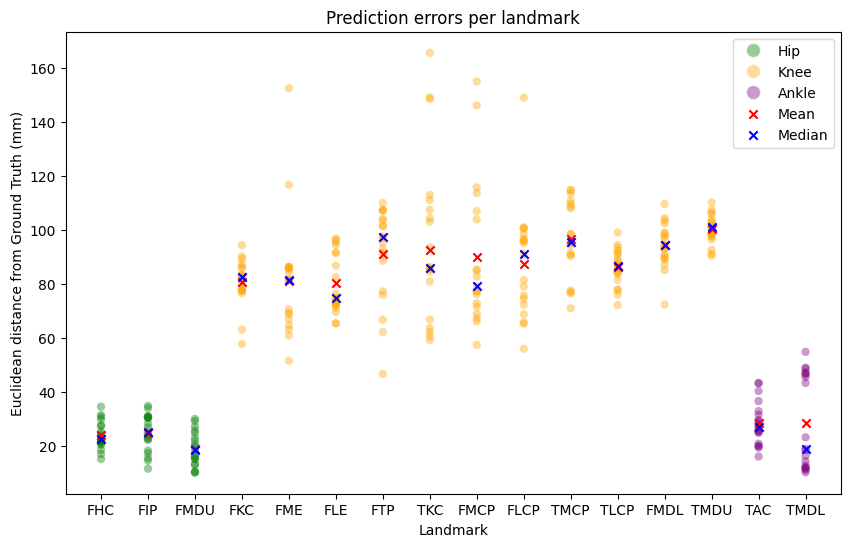

In [465]:
# show only data points
plt.figure(figsize=(10, 6))

# plot all data points
for i, (row, colour) in enumerate(zip(data, colours)):
    # Generate x positions for each landmarks's data points
    x_positions = np.full(shape=row.shape, fill_value=i)
    plt.scatter(x_positions, row, color=colour, alpha=0.4, edgecolor='none')

# plot means
means = stats_lmk[:,0]
mean_plot = plt.scatter(range(len(means)), means, color='red', marker = "x", label='Mean')


# plot medians
medians = stats_lmk[:,1]
median_plot = plt.scatter(range(len(medians)), medians, color='blue', marker = "x", label='Median')
    

plt.xticks(ticks=np.arange(0, 16), labels=landmarks)
plt.xlabel('Landmark')
plt.ylabel('Euclidean distance from Ground Truth (mm)')
plt.title('Prediction errors per landmark')

# legend for joints
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Hip', markersize=10, alpha=0.4),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='Knee', markersize=10, alpha=0.4),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', label='Ankle', markersize=10, alpha=0.4),
                   mean_plot,
                   median_plot]
plt.legend(handles=legend_elements)

# Save plot as image
plt.savefig(f"images/scatterplot_{ds}.png")

plt.show()

Statistical tests

In [498]:
# ANOVA test
# Assume statistical difference between hip & ankle vs knee, check within

#1. Check assumptions
data = clean_eu_dist

#1.1 Normality - violated by some datasets

for i in range(len(data)):
    # Perform the Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(data[i])
    
    print(f"Landmark: {landmarks[i]}")
    print(f"Shapiro-Wilk test statistic: {shapiro_stat}")
    print(f"p-value: {shapiro_p}")
    print()

# Interpretation of the p-value:
# p < 0.05: The data is not normally distributed (reject the null hypothesis of normality).
# p >= 0.05: The data is normally distributed (fail to reject the null hypothesis of normality).

# CONCLUSIONS: Not all data is normally distributed

Landmark: FHC
Shapiro-Wilk test statistic: 0.9702009558677673
p-value: 0.780474066734314

Landmark: FIP
Shapiro-Wilk test statistic: 0.9470793604850769
p-value: 0.35204407572746277

Landmark: FMDU
Shapiro-Wilk test statistic: 0.9460957050323486
p-value: 0.3384118676185608

Landmark: FKC
Shapiro-Wilk test statistic: 0.8891935348510742
p-value: 0.031147874891757965

Landmark: FME
Shapiro-Wilk test statistic: 0.7990556955337524
p-value: 0.001107347896322608

Landmark: FLE
Shapiro-Wilk test statistic: 0.8770524859428406
p-value: 0.019084755331277847

Landmark: FTP
Shapiro-Wilk test statistic: 0.8663219213485718
p-value: 0.012509549967944622

Landmark: TKC
Shapiro-Wilk test statistic: 0.9080435037612915
p-value: 0.07947085052728653

Landmark: FMCP
Shapiro-Wilk test statistic: 0.8559249043464661
p-value: 0.00838856678456068

Landmark: FLCP
Shapiro-Wilk test statistic: 0.8788394927978516
p-value: 0.02049555815756321

Landmark: TMCP
Shapiro-Wilk test statistic: 0.922809898853302
p-value: 0.127

In [477]:
#2. Use Kruskal-Wallis test instead of ANOVA as assumptions are not fulfilled

# Perform the Kruskal-Wallis test
hip_and_ankle  = np.concatenate((data[0:hipnum], data[hipnum+kneenum:data_len]))

stat, p_value = stats.kruskal(*hip_and_ankle)
print("Hip and Ankle:")
print(f"Kruskal-Wallis test statistic: {stat}")
print(f"p-value: {p_value}")
print()

stat, p_value = stats.kruskal(*data[hipnum:hipnum+kneenum])
print("Knee:")
print(f"Kruskal-Wallis test statistic: {stat}")
print(f"p-value: {p_value}")
print()

stat, p_value = stats.kruskal(*data[0:hipnum])
print("Hip:")
print(f"Kruskal-Wallis test statistic: {stat}")
print(f"p-value: {p_value}")
print()

stat, p_value = stats.kruskal(*data[hipnum+kneenum:data_len])
print("Ankle:")
print(f"Kruskal-Wallis test statistic: {stat}")
print(f"p-value: {p_value}")
print()

# Interpretation of the p-value:
# p < 0.05: There is a statistically significant difference between the groups.
# p >= 0.05: There is no statistically significant difference between the groups.

# CONCLUSIONS STATISTICAL DIFFERENCE 

Hip and Ankle:
Kruskal-Wallis test statistic: 11.010080582032542
p-value: 0.02645095580019211

Knee:
Kruskal-Wallis test statistic: 46.559525932645194
p-value: 1.1353851061090074e-06

Hip:
Kruskal-Wallis test statistic: 8.477374033404564
p-value: 0.0144265211948046

Ankle:
Kruskal-Wallis test statistic: 0.3582322516731788
p-value: 0.5494896404566826



In [504]:
# CARRY OUT POST-HOC TESTS - Conover test

# Create  DataFrame from the list of numpy arrays
values = np.concatenate(data)  # Concatenate all group data into a single array
group_labels = np.array([landmark for landmark, arr in zip(landmarks, data) for _ in arr])

df = pd.DataFrame({
    'Value': values,
    'Group': group_labels
})

# Perform the Conover test
conover_matrix = sp.posthoc_conover(df, val_col='Value', group_col='Group', p_adjust='holm')

# Reorder the conover_matrix to match the original landmarks order
conover_matrix = conover_matrix.reindex(index=landmarks, columns=landmarks)

print(conover_matrix)

# Save Conover matrix to excel for further analysis
conover_matrix.to_excel('conover_matrix.xlsx', engine='openpyxl')


               FHC           FIP          FMDU           FKC           FME  \
FHC   1.000000e+00  1.000000e+00  1.000000e+00  2.162394e-11  1.160128e-10   
FIP   1.000000e+00  1.000000e+00  1.000000e+00  7.405787e-11  3.901830e-10   
FMDU  1.000000e+00  1.000000e+00  1.000000e+00  1.011434e-14  6.541431e-14   
FKC   2.162394e-11  7.405787e-11  1.011434e-14  1.000000e+00  1.000000e+00   
FME   1.160128e-10  3.901830e-10  6.541431e-14  1.000000e+00  1.000000e+00   
FLE   3.533195e-11  1.181435e-10  1.754011e-14  1.000000e+00  1.000000e+00   
FTP   1.453061e-21  6.638266e-21  1.753600e-25  5.604553e-02  2.210577e-02   
TKC   5.893537e-18  2.480698e-17  1.141160e-21  9.070001e-01  4.902883e-01   
FMCP  1.999233e-15  7.951963e-15  4.869857e-19  1.000000e+00  1.000000e+00   
FLCP  4.515890e-16  1.790301e-15  9.690613e-20  1.000000e+00  1.000000e+00   
TMCP  1.117402e-24  5.405155e-24  1.024798e-28  1.954826e-03  6.486979e-04   
TLCP  2.024960e-15  8.049753e-15  4.946265e-19  1.000000e+00  1.

2. AXIS-DEPENDENT VARIABILITY

In [509]:
# X-Y-Z VARIABILITY
#load raw prediction data
joints = ["hip", "knee", "ankle"]  # List of joints in the specified order
ds = "test"  # Dataset type

# Initialize an empty list to store data from all joints
dist_data = []
x_dist_data = []
y_dist_data = []
z_dist_data = []

for joint in joints:
    # Load the dataset for the current joint
    data = np.load(f"differences/differences_{ds}_{joint}.npy").T
   
    # Append absolute values of loaded data to the list
    x_dist_data.append(np.abs(data[0]))
    y_dist_data.append(np.abs(data[1]))
    z_dist_data.append(np.abs(data[2]))

# Concatenate all the data along the first axis (vertical concatenation)
x_dist_data = np.concatenate(x_dist_data, axis=0)
y_dist_data = np.concatenate(y_dist_data, axis=0)
z_dist_data = np.concatenate(z_dist_data, axis=0)

data_len = (x_dist_data.shape[0])

In [510]:
def plot_axis_errors(axis_data,axis,colours, landmarks):
    
    #stats tables
    data = axis_data # x, y or z
    data_clean = remove_mad_outliers(data)
    
    #calculate stats measures
    stats_lmk = np.zeros((data_len, 3))
    stats_total = np.zeros((4,3))

    #iterate through landmarks
    for i, lmk in enumerate(data_clean):
        mean = np.mean(lmk)
        median = np.median(lmk)
        stdev = np.std(lmk)

        stats_lmk[i] = [mean, median, stdev]

    
    # Create boxplot
    plt.figure(figsize=(9, 6))
    sns.boxplot(data=data.T,fill=False,color='0', medianprops={'color': 'blue'}) #data array must be transpose

    #95 percentile whiskers
    #sns.boxplot(data=data.T,fill=False,color='0', medianprops={'color': 'blue'}, whis=(5,95))

    plt.xticks(ticks=np.arange(0, 16), labels=landmarks)


    # plot all data points
    for i, (row, colour) in enumerate(zip(data, colours)):
        # Generate x positions for each group's data points
        x_positions = np.full(shape=row.shape, fill_value=i)
        plt.scatter(x_positions, row, color=colour, alpha=0.4, edgecolor='none')


    # get mean of each dataset and plot 
    means = stats_lmk[:,0]
    mean_plot = plt.scatter(range(len(means)), means, color='red', marker='x', label='Mean')

    #add median line to legend
    median_line = Line2D([0], [0], color="blue", label='Median')
    
    plt.ylim(0, 150)


    # Labels
    plt.xlabel('Landmark')
    plt.ylabel('Prediction error (mm)')
    plt.title(f'Prediction errors per landmark in {axis} axis')
    plt.legend(handles=[mean_plot, median_line], loc='upper right')

    # Save plot as image
    plt.savefig(f"images/boxplot_{axis}_{ds}.png")

    # Display plot
    plt.show()

    plt.close()

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers



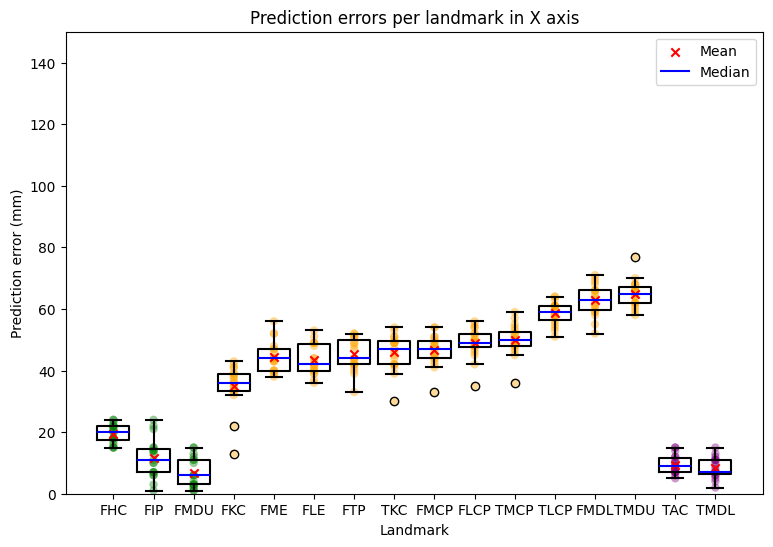

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers



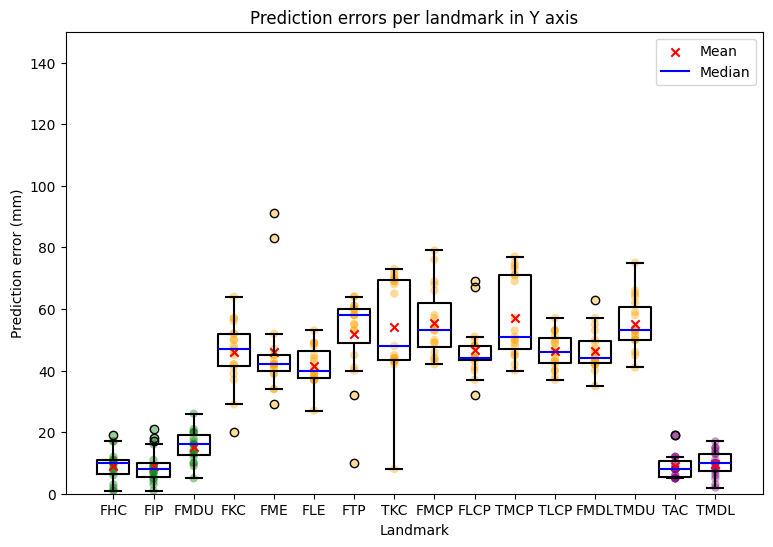

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

Outliers found at indices: [14 18], with values: [139 127]
Removed 2 outliers

Outliers found at indices: [3], with values: [129]
Removed 1 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers



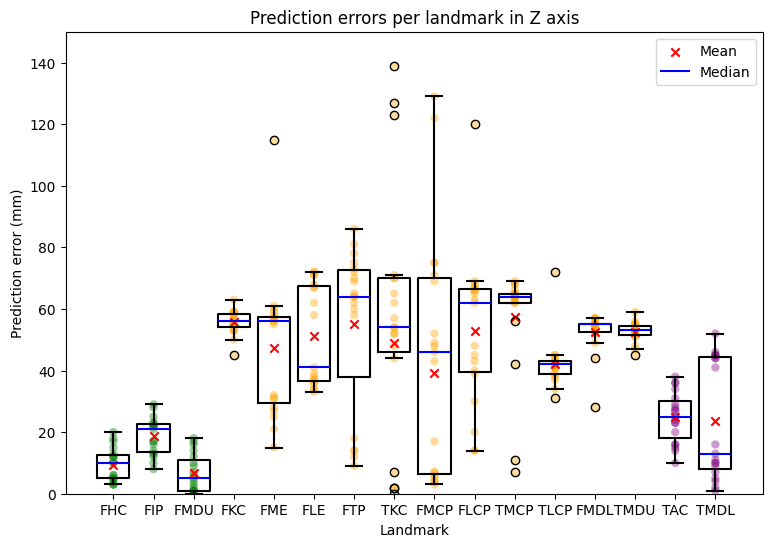

In [507]:
colours = ['green'] * hipnum + ['orange'] * kneenum + ['purple'] * anklenum  # Blue for hip, Green for knee, Red for ankle

for (axis_data, axis) in zip([x_dist_data,y_dist_data,z_dist_data],["X","Y","Z"]):
    plot_axis_errors(axis_data, axis, colours, landmarks)

Statistical analysis

In [528]:
data = remove_mad_outliers(z_dist_data) #x_dist_data, y_dist_data, z_dist_data

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

Outliers found at indices: [14 18], with values: [139 127]
Removed 2 outliers

Outliers found at indices: [3], with values: [129]
Removed 1 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers



In [ ]:
# ANOVA test
#1. Check assumptions - CONCLUSION - DATA IS NOT NORMALLY DISTRIBUTED

# Perform the Shapiro-Wilk test for normality
for i in range(len(data)):
    shapiro_stat, shapiro_p = stats.shapiro(data[i])
    if shapiro_p < 0.05:
        print("Normality cannot be assumed")

# Interpretation of the p-value:
# p < 0.05: The data is not normally distributed (reject the null hypothesis of normality).
# p >= 0.05: The data is normally distributed (fail to reject the null hypothesis of normality).

#CONCLUSION - Normality cannot be assumed for any axis

In [522]:
#2. Use Kruskal-Wallis test instead of ANOVA as assumptions are not fulfilled

# Perform the Kruskal-Wallis test
stat, p_value = stats.kruskal(*data) 

print(f"Kruskal-Wallis test statistic: {stat}")
print(f"p-value: {p_value}")

# Interpretation of the p-value:
# p < 0.05: There is a statistically significant difference between the groups.
# p >= 0.05: There is no statistically significant difference between the groups.

# CONCLUSION: STATISTICAL DIFFERENCE

Kruskal-Wallis test statistic: 216.60818869305857
p-value: 8.786202030669085e-38


In [529]:
#3. Post-hoc test - Conover
# CARRY OUT POST-HOC TESTS - Conover test

# Create  DataFrame from the list of numpy arrays
values = np.concatenate(data)  # Concatenate all group data into a single array
group_labels = np.array([landmark for landmark, arr in zip(landmarks, data) for _ in arr])

df = pd.DataFrame({
    'Value': values,
    'Group': group_labels
})

# Perform the Conover test
conover_matrix = sp.posthoc_conover(df, val_col='Value', group_col='Group', p_adjust='holm')

# Reorder the conover_matrix to match the original landmarks order
conover_matrix = conover_matrix.reindex(index=landmarks, columns=landmarks)

print(conover_matrix)

# Save Conover matrix to excel for further analysis
conover_matrix.to_excel('conover_matrix_z.xlsx', engine='openpyxl')

               FHC           FIP          FMDU           FKC           FME  \
FHC   1.000000e+00  1.000000e+00  1.000000e+00  4.672361e-13  2.620787e-08   
FIP   1.000000e+00  1.000000e+00  9.701266e-01  2.776566e-08  2.110968e-04   
FMDU  1.000000e+00  9.701266e-01  1.000000e+00  8.066626e-15  7.933180e-10   
FKC   4.672361e-13  2.776566e-08  8.066626e-15  1.000000e+00  1.000000e+00   
FME   2.620787e-08  2.110968e-04  7.933180e-10  1.000000e+00  1.000000e+00   
FLE   1.777952e-10  3.951084e-06  4.072785e-12  1.000000e+00  1.000000e+00   
FTP   1.408139e-13  1.001622e-08  2.339946e-15  1.000000e+00  1.000000e+00   
TKC   8.067803e-08  4.039772e-04  2.959929e-09  1.000000e+00  1.000000e+00   
FMCP  3.022534e-04  2.021129e-01  2.110048e-05  3.907621e-02  1.000000e+00   
FLCP  7.038349e-11  1.878462e-06  1.540521e-12  1.000000e+00  1.000000e+00   
TMCP  2.763413e-15  3.368972e-10  3.962895e-17  1.000000e+00  7.167989e-01   
TLCP  5.274033e-05  6.355566e-02  2.945834e-06  9.680183e-02  1.

3. Global X-Y-Z Analysis

In [450]:
# All landmarks
# Concatenate all the data for stats calculations
x_dist_data = np.concatenate(x_dist_data[0:data_len])
y_dist_data = np.concatenate(y_dist_data[0:data_len])
z_dist_data = np.concatenate(z_dist_data[0:data_len])

dist_data = np.array([x_dist_data,y_dist_data,z_dist_data])

In [451]:
# stats
# find and remove outliers
dist_data_clean = remove_mad_outliers(dist_data)

# calculate statistics
means = np.mean(dist_data, axis=1)
medians = np.median(dist_data, axis=1)
stddevs = np.std(dist_data, axis=1)

# Combine stats into new array
stats_diffs = np.array([means, medians, stddevs])

No outliers found.
Removed 0 outliers

No outliers found.
Removed 0 outliers

Outliers found at indices: [ 92 134 147 151 155 162 182], with values: [115 123 139 127 129 122 120]
Removed 7 outliers



[37.61513158 37.4375     40.73355263]


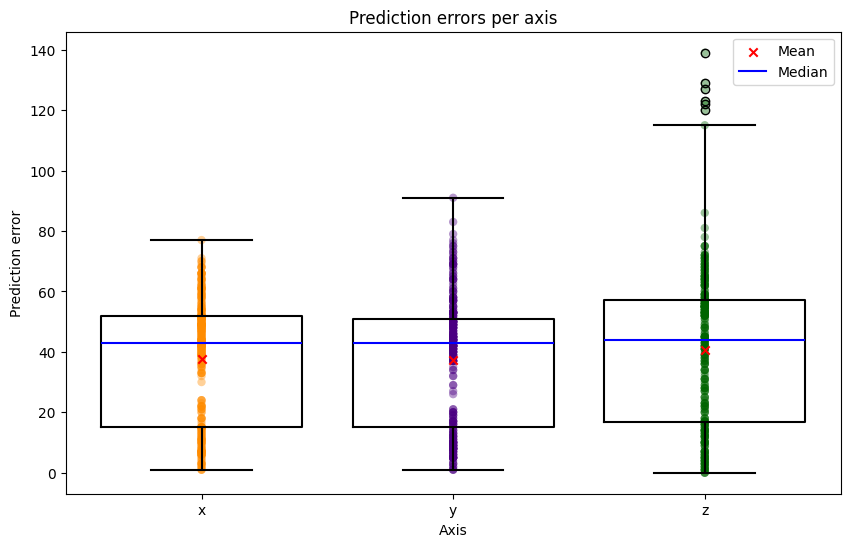

In [453]:
# plot all x y and z
data = dist_data

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data.T,fill=False,color='0', medianprops={'color': 'blue'}) #data array must be transposed

plt.xticks(ticks=np.arange(0, 3), labels=["x","y","z"])

# colours for each joint
colours = ['darkorange'] + ['indigo'] + ['darkgreen']  # green for x, orange for y, purple for z

# plot all data points
for i, (row, colour) in enumerate(zip(data, colours)):
    # Generate x positions for each group's data points
    x_positions = np.full(shape=row.shape, fill_value=i)
    plt.scatter(x_positions, row, color=colour, alpha=0.4, edgecolor='none')


# get mean of each dataset and plot 
means = stats_diffs[0]
print(means)
mean_plot = plt.scatter(range(len(means)), means, color='red', marker='x', label='Mean')

#add median line to legend
median_line = Line2D([0], [0], color="blue", label='Median')

# Labels
plt.xlabel('Axis')
plt.ylabel('Prediction error')
plt.title('Prediction errors per axis')
plt.legend(handles=[mean_plot, median_line], loc='upper right')

# Save plot as image
plt.savefig(f"images/boxplot_xyz_{ds}.png")

# Display plot
plt.show()
plt.close()

Statistical tests

In [454]:
# ANOVA test
#1. Check assumptions - CONCLUSION - DATA IS NOT NORMALLY DISTRIBUTED

data = x_dist_data #x_dist_data, y_dist_data, z_dist_data

# Perform the Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(data)

print(f"Shapiro-Wilk test statistic: {shapiro_stat}")
print(f"p-value: {shapiro_p}")

# Interpretation of the p-value:
# p < 0.05: The data is not normally distributed (reject the null hypothesis of normality).
# p >= 0.05: The data is normally distributed (fail to reject the null hypothesis of normality).


Shapiro-Wilk test statistic: 0.9194451570510864
p-value: 1.0096038588480738e-11


In [455]:
#1.2 homogeneity of variances - NOT FULFILLED EITHER
# Perform Levene's test for homogeneity of variances
stat, p_value = stats.levene(x_dist_data, y_dist_data, z_dist_data)

print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

# If the p-value is less than 0.05, the variances are statistically significantly different.
# If the p-value is greater than 0.05, there is not enough evidence to suggest the variances are different.


Levene's test statistic: 10.591253451129091
p-value: 2.8382629450968873e-05


In [458]:
#2. Use Kruskal-Wallis test instead of ANOVA as assumptions are not fulfilled

# Perform the Kruskal-Wallis test
stat, p_value = stats.kruskal(dist_data_clean[0],dist_data_clean[1],dist_data_clean[2]) # Add more groups if you have more

print(f"Kruskal-Wallis test statistic: {stat}")
print(f"p-value: {p_value}")

# Interpretation of the p-value:
# p < 0.05: There is a statistically significant difference between the groups.
# p >= 0.05: There is no statistically significant difference between the groups.

# CONCLUSION: NO STATISTICAL DIFFERENCE

Kruskal-Wallis test statistic: 2.1724095127352814
p-value: 0.3374949416898014


4. Comparison of Inter-observer and Machine Learning errors

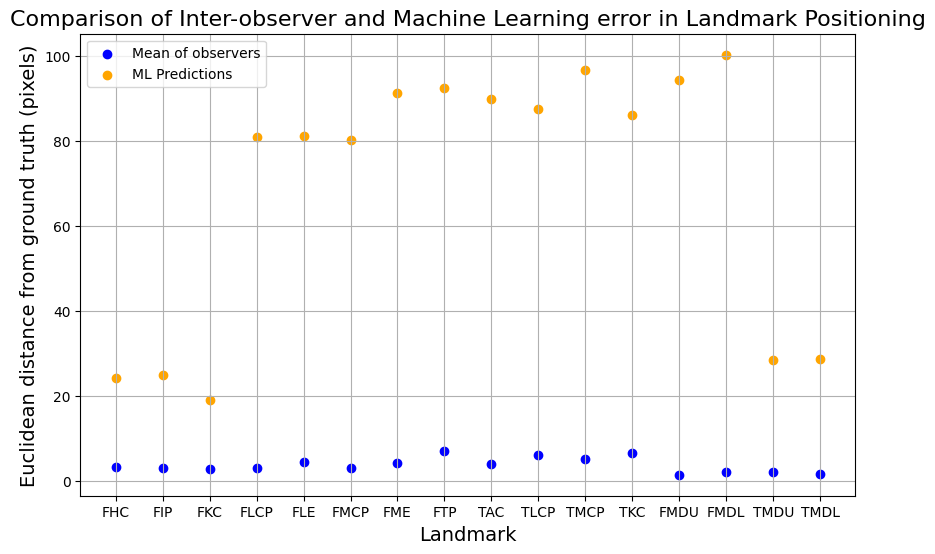

In [543]:
# Values for observers and ML euclidean distances for each landmark

# obtained from euclidian_distance_plots_code.ipynb
observers_eu = np.array([
    3.249221982040202, 3.0098082099999806, 2.7769823225162664, 3.111172214924637,
    4.460553544605045, 2.984806406646415, 4.151551850149216, 7.073307136984528,
    3.854489167526949, 6.147623285039666, 5.047020490814103, 6.489447835897545,
    1.4295975033674129, 2.0785382635720504, 1.988243826690442, 1.637247669589538
])

#stats_lmk[:,0]
ml_eu = np.array([
    24.19270068, 24.96966233, 19.11955613, 80.91636589, 81.30992909,
    80.26595704, 91.31978214, 92.61710158, 89.98415548, 87.59783928,
    96.72372079, 86.20276729, 94.35261534, 100.36708264, 28.53889977,
    28.70215412
])

# Landmark labels
landmarks = [
    "FHC", "FIP", "FKC", "FLCP", "FLE", "FMCP", "FME", "FTP", "TAC", "TLCP",
    "TMCP", "TKC", "FMDU", "FMDL", "TMDU", "TMDL"
]


# Plotting the graph similar to the one provided
plt.figure(figsize=(10, 6))

# Scatter plots for each observer
plt.scatter(landmarks, observers_eu, color='blue', label='Mean of observers')
plt.scatter(landmarks, ml_eu, color='orange', label='ML Predictions')


# Customizing the plot
plt.xlabel('Landmark', fontsize=14)
plt.ylabel('Euclidean distance from ground truth (pixels)', fontsize=14)
plt.title('Comparison of Inter-observer and Machine Learning error in Landmark Positioning', fontsize=16)
plt.legend()
plt.grid(True)

plt.savefig(f"images/obs_vs_ml.png")

# Show the plot
plt.show()